In [1]:
from Utils.FS import file
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
from scipy.sparse import coo_matrix, dok_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from nltk.corpus import stopwords
import tensorflow as tf
import math

In [2]:
np.random.seed(1234)

In [3]:
sents = brown.sents()
sents = [[token.lower() for token in sent] for sent in sents]
words = brown.words()
words = [word.lower() for word in words]

In [4]:
print("Number of tokens: {}".format(len(words)))
print("Number of sentences: {}".format(len(sents)))
print("Longest sentences length: {}".format(max([len(sent) for sent in sents])))

Number of tokens: 1161192
Number of sentences: 57340
Longest sentences length: 180


In [5]:
def words2dicts(words):
    f_dict = {}
    index = 0
    for word in words:
        if not word in f_dict.keys():
            f_dict[word] = index
            index = index + 1
        
    return f_dict, { v:k for k, v in f_dict.items()}

In [6]:
words_dict, inv_words_dict = words2dicts(words)
words_size = len(words_dict)
print("Number of unique tokens: {}".format(words_size))

Number of unique tokens: 49815


In [7]:
def singleSideWindow(sents, words_dict, window_size, reverse = False):
    window = []
    row = []
    col = []
    data = []
        
    for sent in reversed(sents) if reverse else sents:
        for word in reversed(sent) if reverse else sent:
            for w in window:
                if w == word:
                    continue
                row.append(words_dict[word])
                col.append(words_dict[w])
                data.append(1)
            if len(window) == window_size:
                window.pop(0)
            window.append(word)
    return coo_matrix((data, (row, col)), shape=(len(words_dict), len(words_dict)), dtype='float64')
    

def sents2wordContextMatrix(sents, words_dict, window_size = 5):
    m = coo_matrix((words_size, words_size), 'float64')
    
    print('Doing forward pass...')
    m += singleSideWindow(sents, words_dict, window_size)
    
    print('Doing backward pass...')
    m += singleSideWindow(sents, words_dict, window_size, True)
    
    return m

def sents2wordCoocurrenceMatrix(sents, words_dict, window_size = 10):
    #don't really care edge cases....

    window = []
    row = []
    col = []
    data = []
    for sent in sents:
        for word in sent:
            for i in range(len(window)- 1):
                for j in range(i+1, len(window)):
                    row += [words_dict[window[i]], words_dict[window[j]]]
                    col += [words_dict[window[j]], words_dict[window[i]]]
                    data += [1, 1]
            if len(window) == window_size:
                window.pop(0)
            window.append(word)
    print('Preparing sparse matrix...')
    print('Length of data: {}'.format(len(data)))
    return coo_matrix((data, (row,col)), shape=(words_size, words_size), dtype='float64').multiply(1/len(data))


In [8]:
def sents2batchGenerator(sents, words_dict, window_size = 5, batch_size=32):
    window = ['--' for i in range(window_size)]
    size = 0
    c = []
    w = []
    for sent in sents:
        for word in sent:
            for context in window:
                c.append(words_dict[context])
                w.append([words_dict[word]])
                size = size + 1
                if(size == batch_size):
                    yield c, w
                    c = []
                    w = []
                    size = 0
            window.pop(0)
            window.append(word)
    return c, w

In [9]:
def sents2freq(sents):
    freq = {}
    for sent in sents:
        for word in sent:
            if word in freq.keys():
                freq[word] += 1
            else:
                freq[word] = 1
    return freq

words_freq = sents2freq(sents)

In [10]:
WINDOW_SIZE = 5
BATCH_SIZE = 32
generator = sents2batchGenerator(sents, words_dict, window_size = WINDOW_SIZE, batch_size=BATCH_SIZE)
#X = []
#y = []
#for context, word in generator:
#    X.append(context)
#    y.append(word)
#   
#print(len(y))

In [11]:
DIMENSION = 50
VOCABULAY_SIZE = len(words_dict)
NEGATIVE_SAMPLE = 64
BATCH_SIZE = 32

graph = tf.Graph()

with graph.as_default():
    
    inputs = tf.placeholder(tf.int32, shape=[BATCH_SIZE])
    labels = tf.placeholder(tf.int32, shape=[BATCH_SIZE, 1])

    with tf.device('/cpu:0'):
    
        embeddings = tf.Variable(
            tf.random_uniform([VOCABULAY_SIZE, DIMENSION], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, inputs, max_norm=1)

        nce_weights = tf.Variable(
            tf.truncated_normal([VOCABULAY_SIZE, DIMENSION],
                                stddev=1.0 / math.sqrt(DIMENSION)))
        nce_biases = tf.Variable(tf.zeros([VOCABULAY_SIZE]))

        loss = tf.reduce_mean(
          tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=labels,
                     inputs=embed,
                     num_sampled=NEGATIVE_SAMPLE,
                     num_classes=VOCABULAY_SIZE))

        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
        
        init = tf.global_variables_initializer()

In [12]:
num_steps = 100000

with tf.Session(graph=graph) as session:
    init.run()
      
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = next(generator)
        feed_dict = {inputs: batch_inputs, labels: batch_labels}

        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                print('Average loss at step ', step, ': ', average_loss)
                average_loss = 0

    final_embeddings = embeddings.eval()

Average loss at step  2000 :  154.47096365
Average loss at step  4000 :  99.3055699444
Average loss at step  6000 :  76.4808086681
Average loss at step  8000 :  61.9410145874
Average loss at step  10000 :  50.6845374207
Average loss at step  12000 :  42.9397992277
Average loss at step  14000 :  35.4400403545
Average loss at step  16000 :  30.7894225361
Average loss at step  18000 :  26.3131490629
Average loss at step  20000 :  22.8403643361
Average loss at step  22000 :  19.6928500494
Average loss at step  24000 :  17.6644680426
Average loss at step  26000 :  16.099804433
Average loss at step  28000 :  14.8131263849
Average loss at step  30000 :  12.8737209162
Average loss at step  32000 :  12.1032612227
Average loss at step  34000 :  10.3128975435
Average loss at step  36000 :  9.07321505821
Average loss at step  38000 :  8.58369643378
Average loss at step  40000 :  8.20175399959
Average loss at step  42000 :  8.37985054421
Average loss at step  44000 :  7.51407368767
Average loss at 

In [13]:

from sklearn.preprocessing import normalize

normalize(final_embeddings, norm='l2', axis=1, copy=False)
print(final_embeddings.shape)

(49815, 50)


In [14]:
sum((final_embeddings[2] ** 2))

0.99999997702954602

In [15]:
words_vec = {}
for i in range(final_embeddings.shape[0]):
    words_vec[inv_words_dict[i]] = final_embeddings[i]

In [16]:
def plotData(vocabs, X, Y):
    plt.clf()
    plt.figure(figsize=(36, 36))
    plt.scatter(X, Y)
    plt.axis([min(X), max(X), min(Y), max(Y)])
    for label, x, y in zip(vocabs, X, Y):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()    

In [17]:
def plot(vocabs, words_vec):
    X = [words_vec[vocab][0] for vocab in vocabs]
    Y = [words_vec[vocab][1] for vocab in vocabs]
    plotData(vocabs, X, Y)

In [18]:
def plotTSNE(vocabs, vectors):
    tsne = TSNE(perplexity=30, n_components=2, n_iter=5000, random_state = 7890, method='exact')
    #np.set_printoptions(suppress=True)
    data = np.array([vectors[vocab] for vocab in vocabs])    
    DATA = tsne.fit_transform(data)
    X = DATA[:, 0]
    Y = DATA[:, 1]
    
    plotData(vocabs, X, Y)

In [19]:
from DataLoader import GloVe

glove = GloVe.load2('./data/GloVe/glove.6B.50d.txt')

Start: Loading Glove Model
End: Loaded 400000 rows.


In [20]:
vocabs = ['man', 'woman', 'king', 'queen', 'male', 'female', 'boy', 'girl']
np.random.seed(1234)

random_vocabs = []
for i in np.random.randint(0, len(words_dict), 2000):
    if inv_words_dict[i] in glove.keys():
        random_vocabs.append(inv_words_dict[i])
        
print(len(random_vocabs))

1616


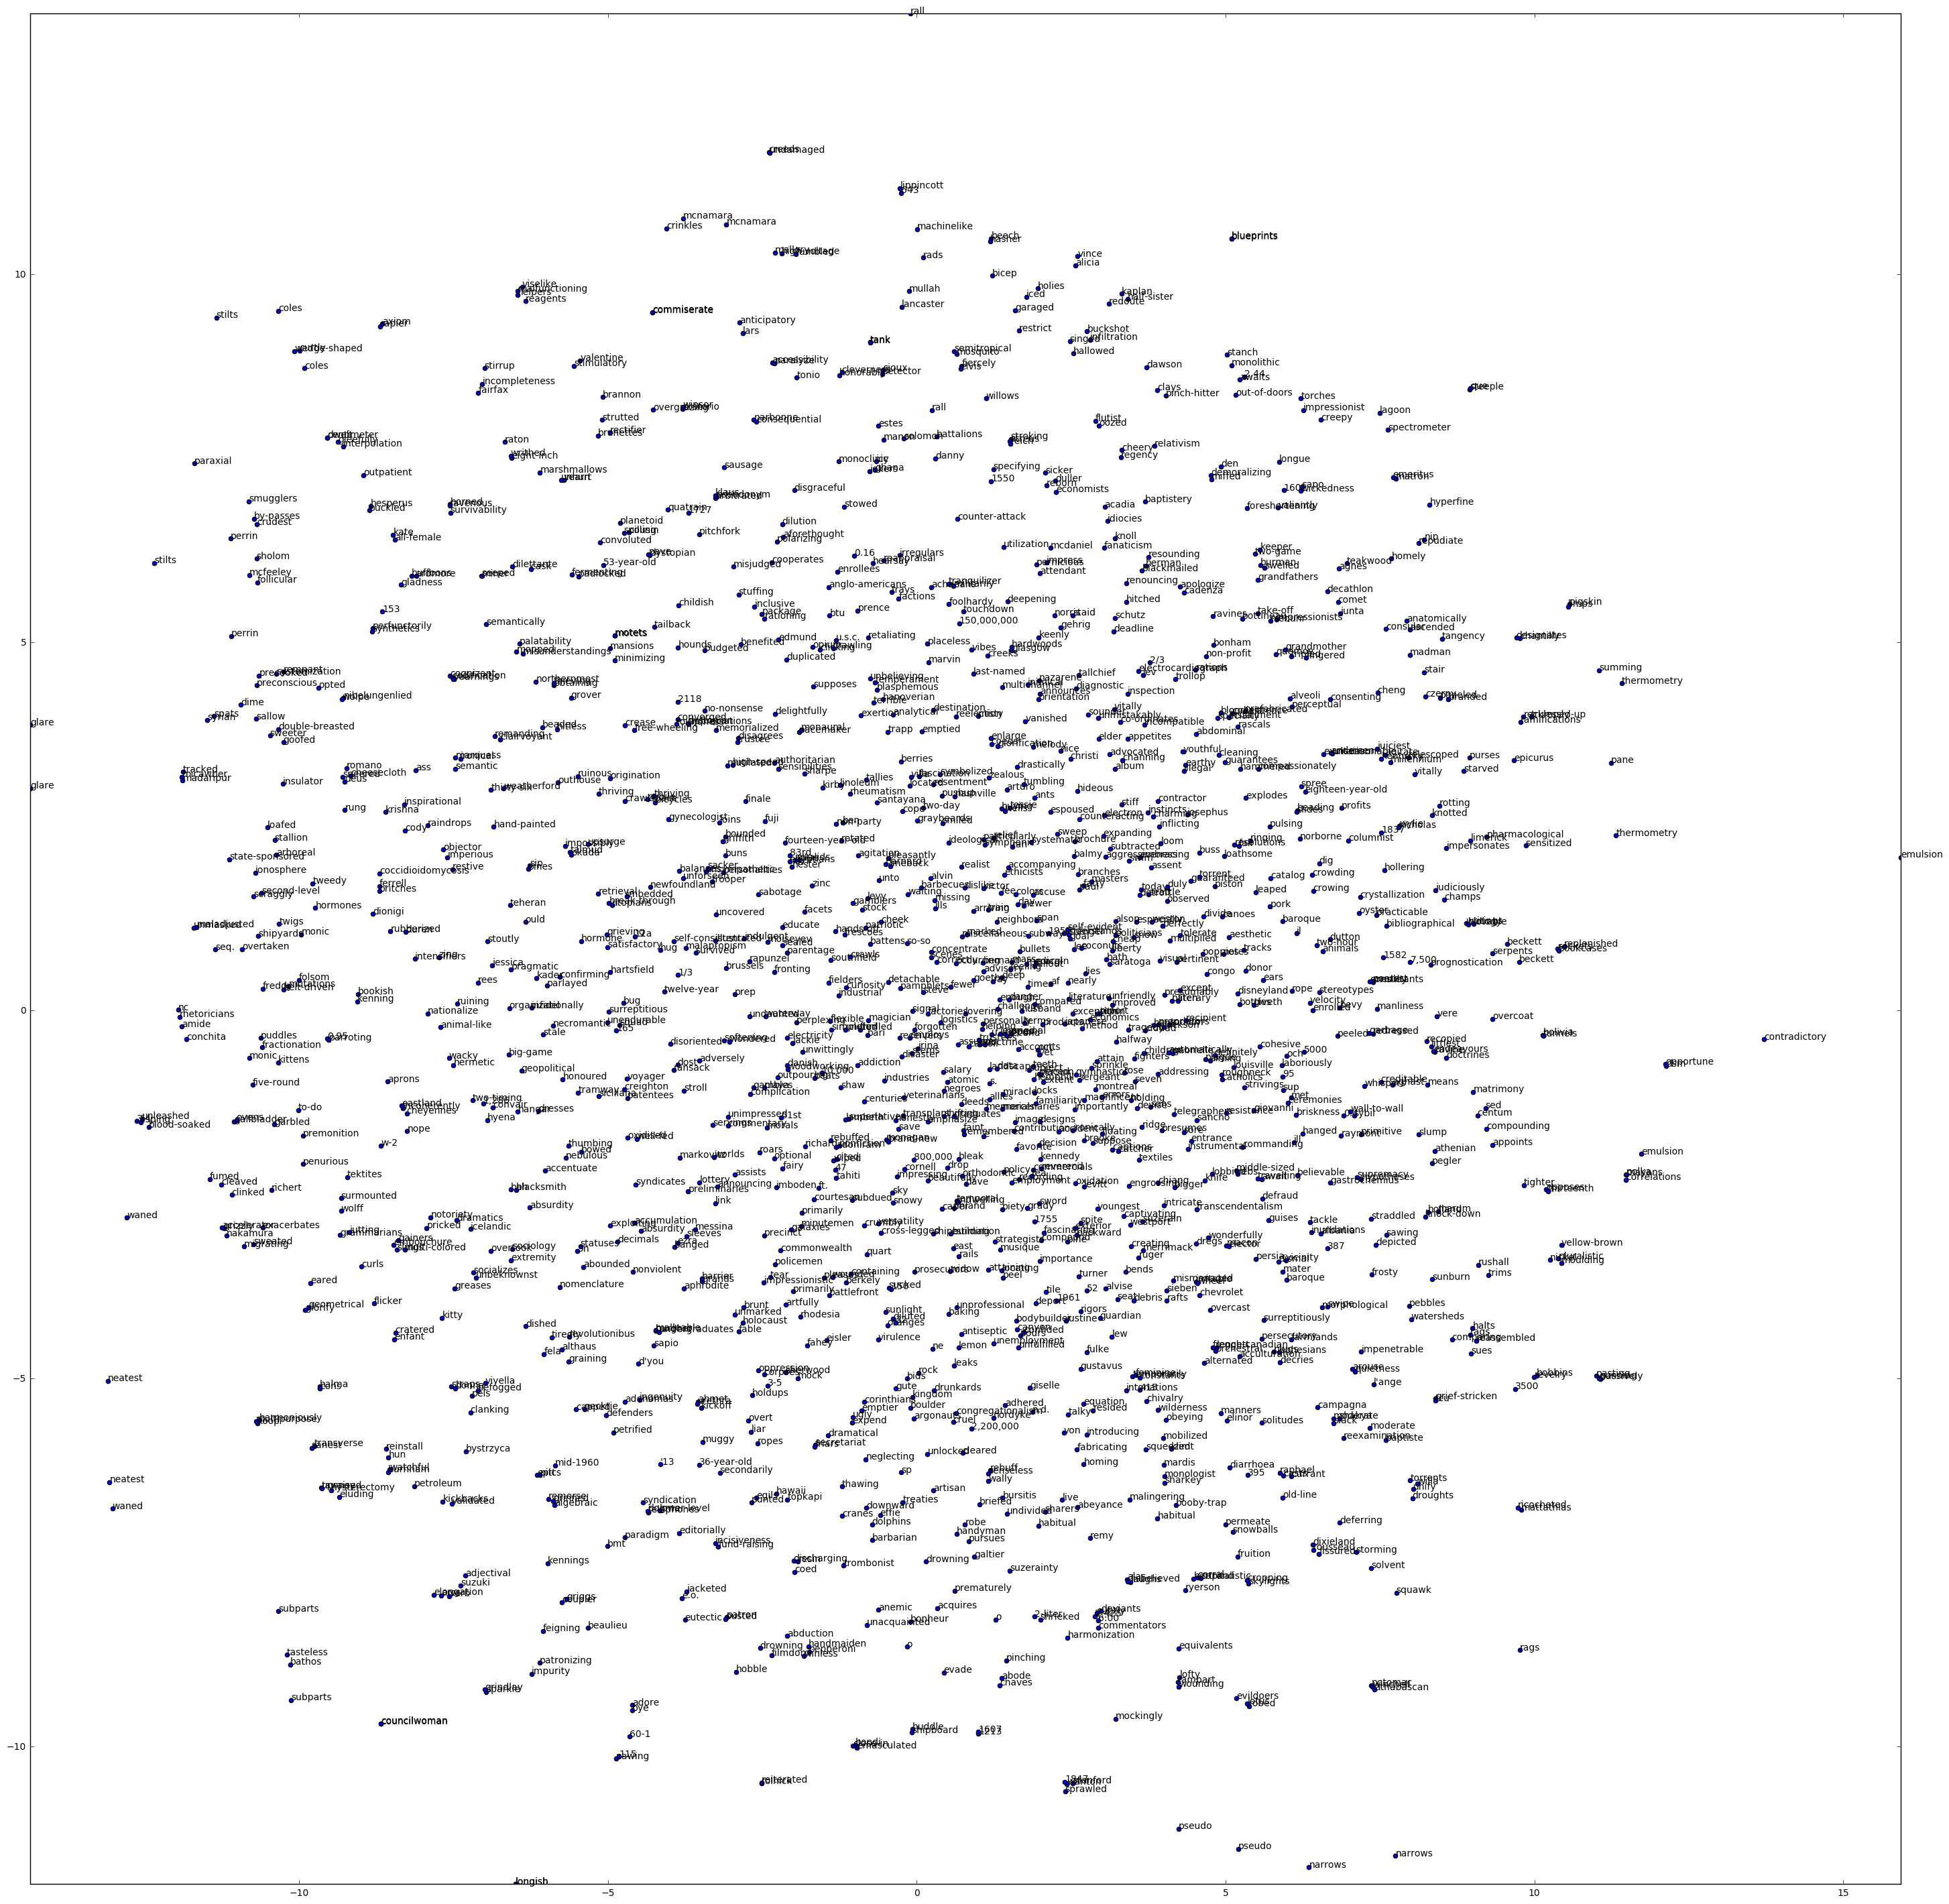

In [21]:
plotTSNE(random_vocabs, words_vec)

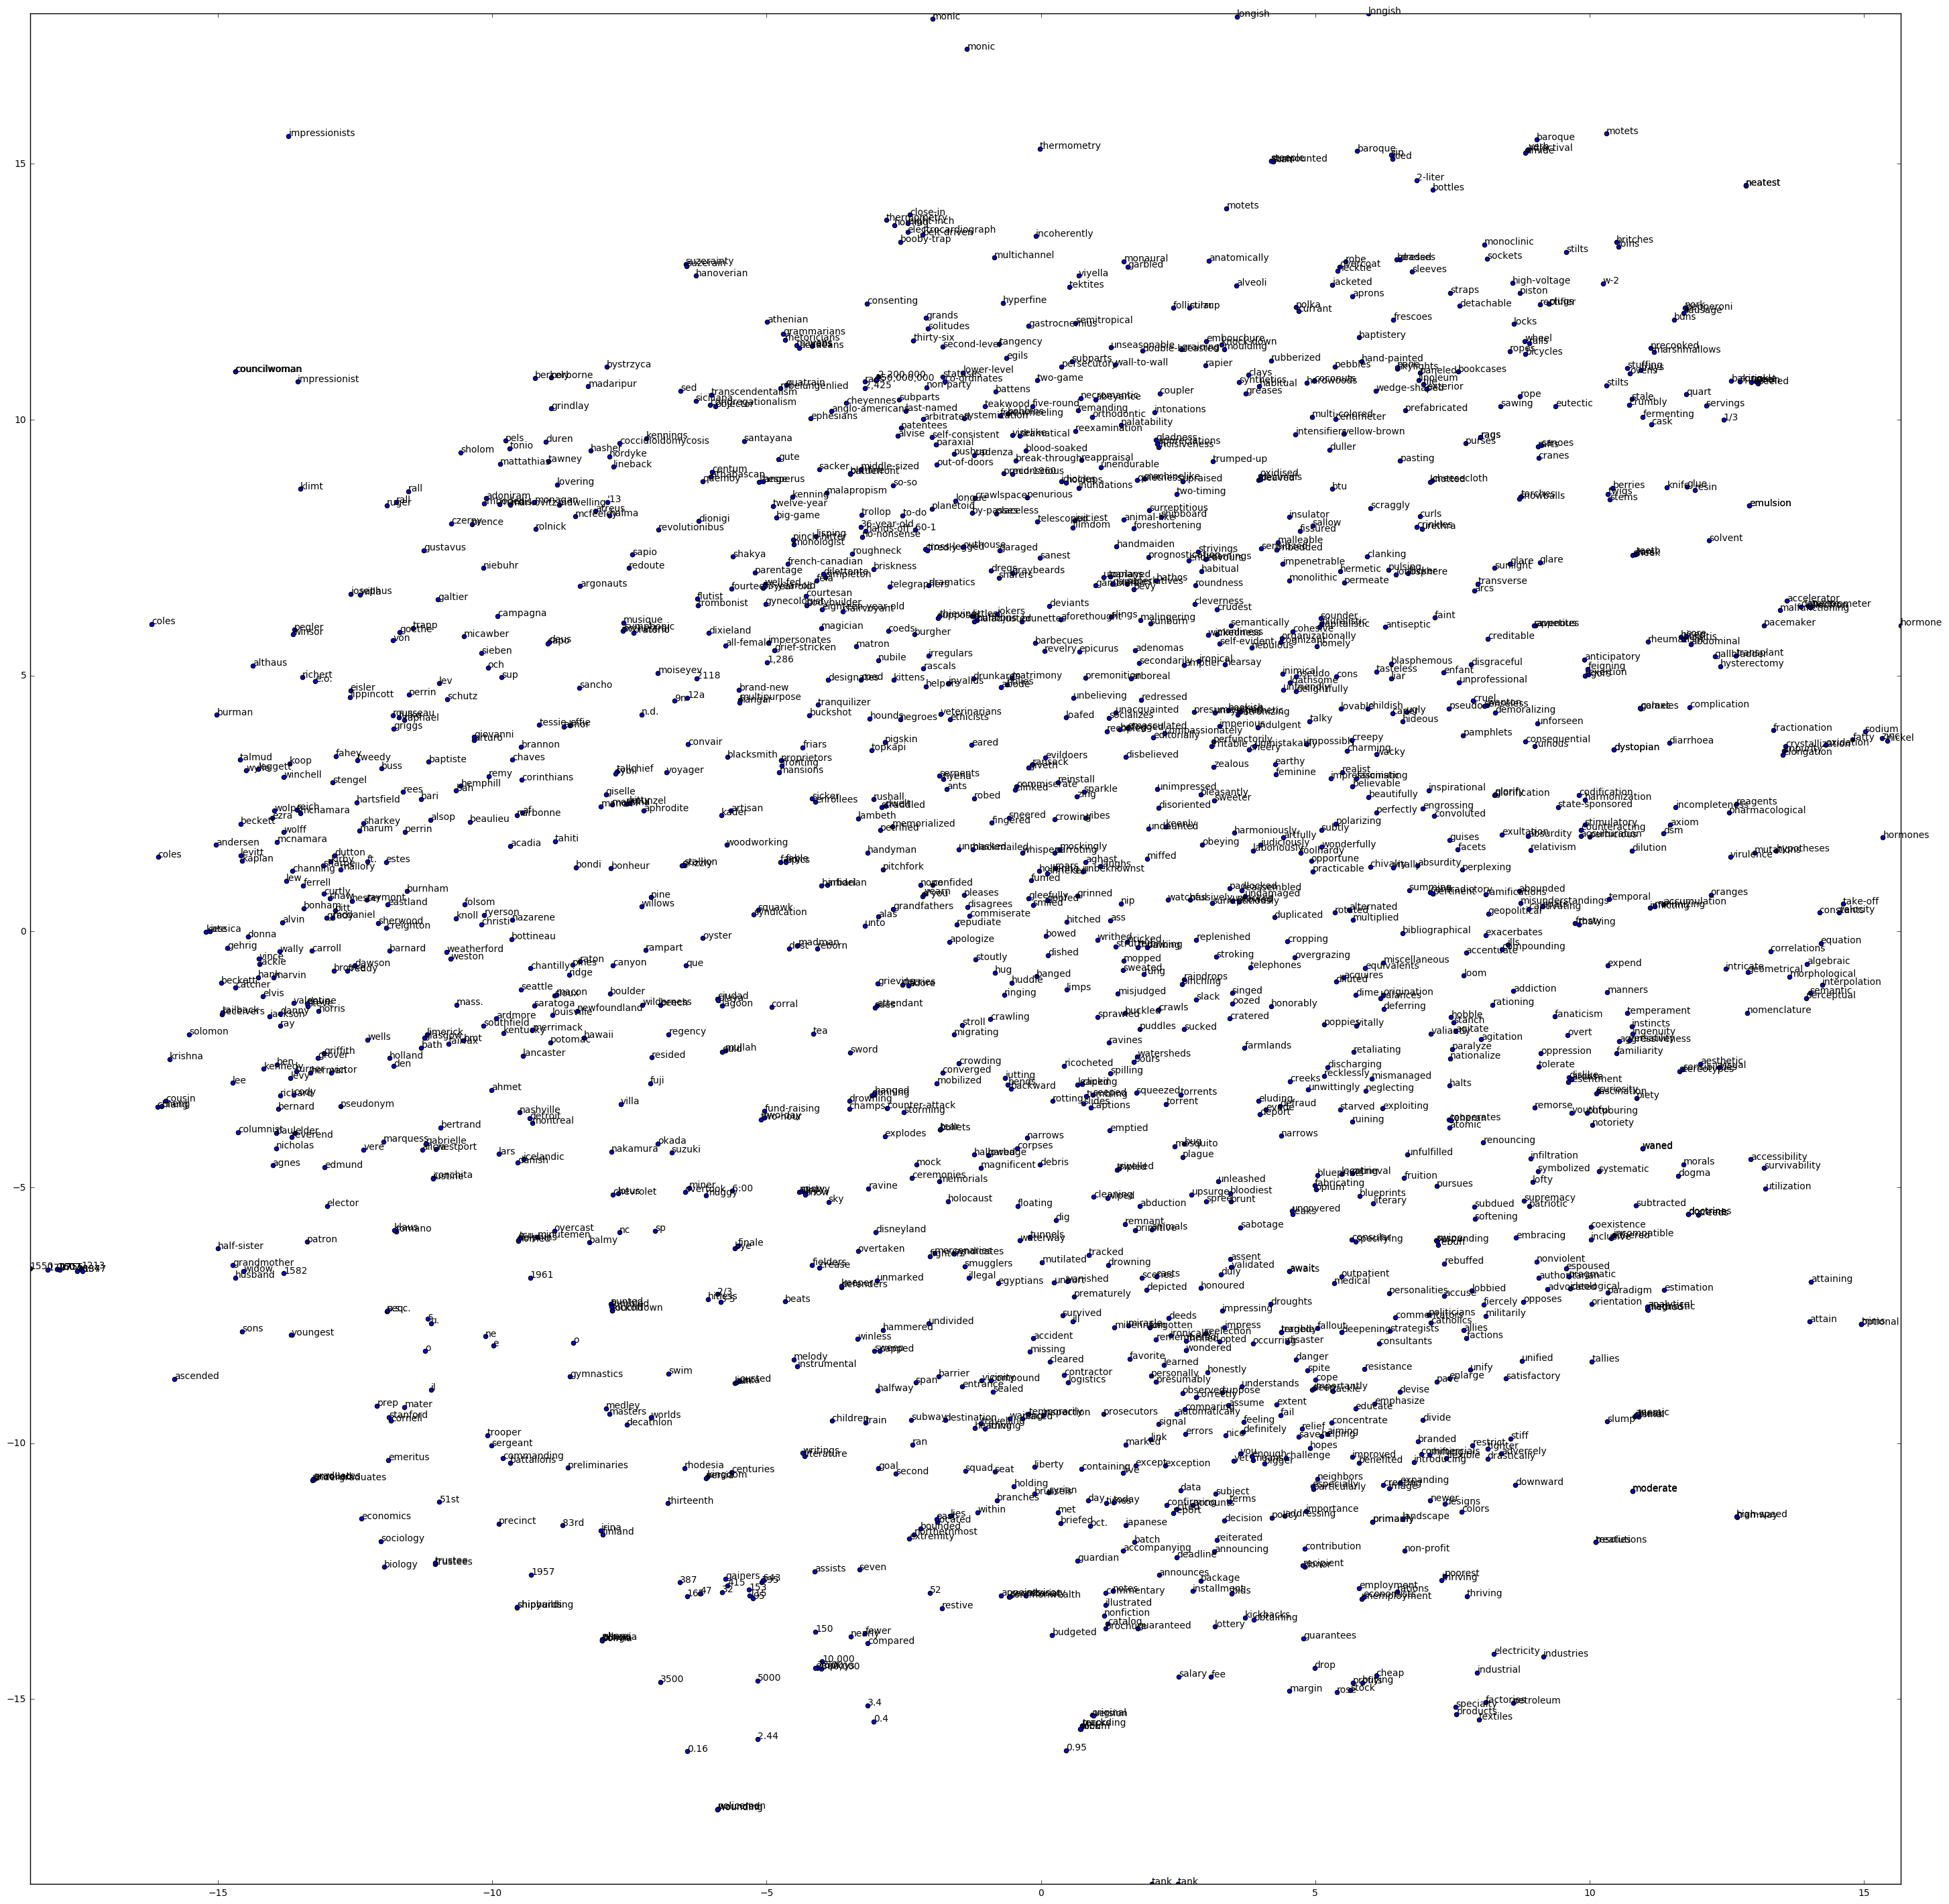

In [22]:
plotTSNE(random_vocabs, glove)

In [80]:
def cloestWord(word, words_vec, count = 10, method=None):
    if method == 'cos':
        dist = np.array([ sum(words_vec[word] * words_vec[key]) for key in words_vec.keys()])
        top_ten = dist.argsort()[::-1][:10]
    else:
        dist = np.array([ sum(np.square(np.array(words_vec[word]) - np.array(words_vec[key]))) for key in words_vec.keys()])
        top_ten = dist.argsort()[:10]
    return [list(words_vec.keys())[i] for i in top_ten]

In [81]:
cloestWord('man', words_vec, method='cos')

['man',
 'national',
 'district',
 'love',
 'year',
 'school',
 'men',
 'book',
 'social',
 'political']

In [82]:
print(cloestWord('man', words_vec, method='cos'))
print(cloestWord('man', glove))

['man', 'national', 'district', 'love', 'year', 'school', 'men', 'book', 'social', 'political']
['man', 'woman', 'another', 'boy', 'one', 'old', 'turned', 'whose', 'himself', 'who']


In [83]:
print(cloestWord('woman', words_vec, method='cos'))
print(cloestWord('woman', glove))

['woman', 'commission', 'recently', 'boy', 'equipment', 'like', 'runs', 'shares', 'stations', 'served']
['woman', 'girl', 'man', 'mother', 'boy', 'her', 'she', 'herself', 'victim', 'child']


In [84]:
print(cloestWord('however', words_vec, method='cos'))
print(cloestWord('however', glove))

['however', 'course', 'therefore', 'see', 'a.', 'third', 'dr.', 'william', 'clear', 'ago']
['however', 'although', 'though', 'as', 'both', 'latter', 'also', '.', 'same', 'fact']


In [85]:
print(cloestWord('his', words_vec, method='cos'))
print(cloestWord('his', glove))

['his', 'states', 'men', 'our', 'national', 'its', 'love', 'community', 'political', 'social']
['his', 'he', 'himself', 'him', 'took', 'came', 'her', 'when', 'having', 'she']


In [86]:
print(cloestWord('zero', words_vec, method='cos'))
print(cloestWord('zero', glove))

['zero', 'preoccupation', 'exceptional', 'julie', 'tight', 'tee', 'bunk', 'profession', 'laughter', 'bulk']
['zero', 'mean', 'assuming', 'hence', 'actual', 'approaching', 'comparable', 'measured', 'limit', 'comparison']


In [87]:
print(cloestWord('one', words_vec, method='cos'))
print(cloestWord('one', glove))

['one', 'matter', 'full', 'university', 'cost', 'center', 'department', 'form', 'study', 'side']
['one', 'another', 'only', 'same', '.', 'as', 'well', 'but', 'with', 'making']


In [88]:
print(cloestWord('two', words_vec, method='cos'))
print(cloestWord('two', glove))

['two', 'u.s.', 'four', '25', 'street', 'british', 'union', 'last', 'church', 'whole']
['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'with', 'several']
